In [1]:
# Cell 1: 导入必要的包
import torch
from torch.utils.data import DataLoader, Dataset
import pickle
import numpy as np
from ppq.api import espdl_quantize_onnx
from ppq.core import TargetPlatform


    ___________ ____        ____  ____  ____ 
   / ____/ ___// __ \      / __ \/ __ \/ __ \
  / __/  \__ \/ /_/ /_____/ /_/ / /_/ / / / /
 / /___ ___/ / ____/_____/ ____/ ____/ /_/ / 
/_____//____/_/         /_/   /_/    \___\_\ 




In [2]:
# Cell 2: 准备校准数据集
class CalibrationDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X).unsqueeze(1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

# 加载校准数据
with open('../dataset/cal.pkl', 'rb') as f:
    X_cal, _ = pickle.load(f)

cal_dataset = CalibrationDataset(X_cal)
cal_loader = DataLoader(cal_dataset, batch_size=32, shuffle=False)

In [19]:
# Cell 3: 执行量化
ONNX_MODEL_PATH = "../training/gesture_model.onnx"
EXPORT_PATH = "../deployment/model/gesture_model_int8.espdl"
input_shape = [1, 1, 96, 96]

graph = espdl_quantize_onnx(
    onnx_import_file=ONNX_MODEL_PATH,
    espdl_export_file=EXPORT_PATH,
    calib_dataloader=cal_loader,
    calib_steps=500,
    input_shape=[input_shape],
    target="esp32s3",
    num_of_bits=8,
    device="cpu",
    error_report=True,
    verbose=1
)

[16:42:08] PPQ Quantization Fusion Pass Running ...       Finished.
[16:42:08] PPQ Quantize Simplify Pass Running ...         Finished.
[16:42:08] PPQ Parameter Quantization Pass Running ...    Finished.
[16:42:08] PPQ Runtime Calibration Pass Running ...       

Calibration Progress(Phase 2): 100%|██████████| 500/500 [00:41<00:00, 12.16it/s]


Finished.
[16:43:18] PPQ Quantization Alignment Pass Running ...    Finished.
[16:43:18] PPQ Passive Parameter Quantization Running ... Finished.
--------- Network Snapshot ---------
Num of Op:                    [27]
Num of Quantized Op:          [27]
Num of Variable:              [74]
Num of Quantized Var:         [74]
------- Quantization Snapshot ------
Num of Quant Config:          [102]
ACTIVATED:                    [30]
OVERLAPPED:                   [34]
PASSIVE:                      [38]
Network Quantization Finished.


Analysing Graphwise Quantization Error(Phrase 1):: 100%|█| 8/8 [00:00<00:00, 10.
Analysing Graphwise Quantization Error(Phrase 2):: 100%|█| 8/8 [00:01<00:00,  5.


Layer                              | NOISE:SIGNAL POWER RATIO 
/layers/layers.3/conv/conv.6/Conv: | ████████████████████ | 20.000%
/classifier/classifier.2/Gemm:     | ██████████████████   | 17.761%
/layers/layers.3/conv/conv.3/Conv: | ███████████          | 10.979%
/layers/layers.2/conv/conv.6/Conv: | █████████            | 8.646%
/layers/layers.3/conv/conv.0/Conv: | ████████             | 8.431%
/layers/layers.2/conv/conv.3/Conv: | █████                | 4.843%
/layers/layers.1/conv/conv.6/Conv: | █████                | 4.616%
/layers/layers.2/conv/conv.0/Conv: | ████                 | 3.625%
/layers/layers.1/conv/conv.3/Conv: | ███                  | 3.167%
/layers/layers.1/conv/conv.0/Conv: | ██                   | 2.458%
/layers/layers.0/conv/conv.6/Conv: | ██                   | 2.430%
/layers/layers.0/conv/conv.3/Conv: | █                    | 0.681%
/layers/layers.0/conv/conv.0/Conv: |                      | 0.342%
/first/first.0/Conv:               |                      | 0.0

Analysing Layerwise quantization error:: 100%|██| 14/14 [00:10<00:00,  1.28it/s]

Layer                              | NOISE:SIGNAL POWER RATIO 
/first/first.0/Conv:               | ████████████████████ | 3.749%
/layers/layers.1/conv/conv.3/Conv: | ██                   | 0.422%
/layers/layers.3/conv/conv.3/Conv: | ██                   | 0.312%
/layers/layers.0/conv/conv.3/Conv: | █                    | 0.147%
/layers/layers.2/conv/conv.0/Conv: | █                    | 0.140%
/layers/layers.2/conv/conv.3/Conv: | █                    | 0.117%
/layers/layers.0/conv/conv.0/Conv: |                      | 0.095%
/layers/layers.3/conv/conv.0/Conv: |                      | 0.086%
/layers/layers.0/conv/conv.6/Conv: |                      | 0.066%
/layers/layers.1/conv/conv.6/Conv: |                      | 0.052%
/layers/layers.2/conv/conv.6/Conv: |                      | 0.052%
/layers/layers.1/conv/conv.0/Conv: |                      | 0.022%
/classifier/classifier.2/Gemm:     |                      | 0.019%
/layers/layers.3/conv/conv.6/Conv: |                      | 0.009%

In [20]:
# Cell 4: 评估量化后的模型
from ppq.executor import TorchExecutor
import time
from tqdm import tqdm

def evaluate_quantized_model(graph, test_loader, y_test):
    """
    评估量化后的模型性能
    """
    executor = TorchExecutor(graph=graph, device='cpu')
    total_time = 0
    correct = 0
    total = 0
    
    print("\n开始评估量化模型性能...")
    with torch.no_grad():
        for batch in tqdm(test_loader):
            start = time.time()
            outputs = executor.forward(inputs=batch)
            total_time += (time.time() - start)
            
            # 计算准确率
            _, predicted = torch.max(outputs[0], 1)
            total += batch.size(0)
            correct += (predicted == y_test[total-batch.size(0):total]).sum().item()

    # 计算并打印结果
    avg_time = (total_time / len(test_loader)) * 1000  # 转换为毫秒
    accuracy = (correct / total) * 100

    print(f"\n评估结果:")
    print(f"平均推理时间: {avg_time:.2f} ms")
    print(f"模型准确率: {accuracy:.2f}%")
    
    return avg_time, accuracy

# 加载测试数据
with open('../dataset/test.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

# 准备测试数据集
test_dataset = CalibrationDataset(X_test)  # 复用之前的Dataset类
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 执行评估
evaluate_quantized_model(graph, test_loader, y_test)


开始评估量化模型性能...


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.59it/s]


评估结果:
平均推理时间: 114.89 ms
模型准确率: 95.81%


(114.89233493804932, 95.8125)

In [38]:
!ls ../dataset/Web_Images_Processed_Versions

2024-12-04_14-42.png
2024-12-04_14-42_processed_modified.png
2024-12-04_14-42_processed.png
2024-12-04_15-24.png
2024-12-04_15-24_processed_modified.png
2024-12-04_15-24_processed.png
2024-12-04_18-24.png
2024-12-04_18-24_processed_modified.png
2024-12-04_18-24_processed.png
frame_05_03_0130_modified.png
rotated_fist_image_45_degrees.png



预测结果: 

类别: palm, 置信度: 0.0000
类别: l, 置信度: 0.0001
类别: fist, 置信度: 0.0000
类别: thumb, 置信度: 0.0000
类别: index, 置信度: 0.0000
类别: ok, 置信度: 0.0052
类别: c, 置信度: 0.0000
类别: down, 置信度: 0.9947


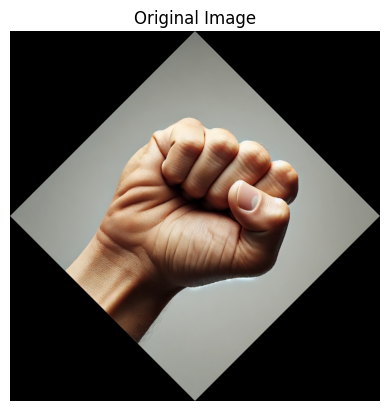

In [39]:
# Cell 5: 使用量化后的模型识别一张图片
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """
    图片预处理函数
    1. 读取图片
    2. 转换为灰度图
    3. 调整大小
    4. 归一化
    """
    # 读取图片
    img = cv2.imread(image_path)
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 调整大小
    TARGET_SIZE = (96, 96)
    resized = cv2.resize(gray, TARGET_SIZE)
    # 归一化
    normalized = resized.astype('float32') / 255.0
    # 添加 batch 和 channel 维度
    image_tensor = torch.FloatTensor(normalized).unsqueeze(0).unsqueeze(0)
    
    return image_tensor, img

def predict_image(graph, image_tensor):
    """
    使用量化后的模型预测图像的类别置信度。
    """
    executor = TorchExecutor(graph=graph, device='cpu')
    with torch.no_grad():
        outputs = executor.forward(inputs=[image_tensor])
        confidences = torch.softmax(outputs[0], dim=1).numpy().flatten()
    
    return confidences

# 定义手势类别
gesture_labels = {
    '00': 'palm',
    '01': 'l',
    '02': 'fist',
    '03': 'thumb',
    '04': 'index',
    '05': 'ok',
    '06': 'c',
    '07': 'down'
}

# 加载并预处理图像
# 请将 "your_image.jpg" 替换为你要预测的图像的实际路径，例如："/path/to/your_image.jpg"
image_path = "../dataset/Web_Images_Processed_Versions/rotated_fist_image_45_degrees.png"  # 这里将 "your_image.jpg" 替换为你要使用的图像路径
image_tensor, original_image = preprocess_image(image_path)

# 使用量化后的模型进行预测
confidences = predict_image(graph, image_tensor)

# 打印模型输出的各个置信度，并关联类别标签
print("\n预测结果: \n")
for idx, confidence in enumerate(confidences):
    label = gesture_labels[f'{idx:02}']
    print(f"类别: {label}, 置信度: {confidence:.4f}")

# 显示原始图片
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()